The objective of this notebook is to serve as a repository of what I've been able to learn about the Transformers architecture, implementing the transformer model using TensorFlow and using the model for the task of French - English translation.

## What is the Transformer Architecture

![The Transformer](https://miro.medium.com/max/700/1*BHzGVskWGS_3jEcYYi6miQ.png)


After the revolution of the research paper from scientists at Google, [Attention is all you need](https://arxiv.org/abs/1706.03762), the field of Natural Language Processing exploded with the new architecture proposed, The Transformer. The Transformer is special because it dealt away with recurrence in its architecture and focused solely on attention mechanisms. 

RNNs, recurrent neural networks, were the start of the art ways of creating ML models in the field of Natural Language Processing. RNNs work well with tasks like sentiment analysis or topic modelling. In order to use RNNs for sequence-sequence tasks like translation, summarization or text generation, the model had to be designed in such a way that one section would be for the encoder (the goal of which is to create a rich representation of the text input) and the other section would be for the decoder (which would receive outputs from the encoder and use it to output tokens for the task at hand). The encoders and decoders are usually similarly designed with the decoder usually having some sort of mask so that future tokens are not seen (otherwise its predictions would be trivial). 

The problem with RNNs is that they're quite slow and can't really handle long sequences. Improvements to the RNNs is the use of attention mechanisms. With the paper from the Google scientists, the Transformer dealt away with recurrence altogether and used only attention mechanisms for its architecture. It uses self-attention to detect subtle ways even distant data elememts in a sequence influence and depend on each other. 

In other to understand how the transformer works, we need to carefully explain its different layers with its basic implentation as is done below.

But first, let's import the necessary dependencies and prepare the dataset to use for training the transformer model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

In [2]:
tf.__version__

'2.8.2'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
eng_path = '/content/drive/MyDrive/small_vocab_en.csv'
fr_path = '/content/drive/MyDrive/small_vocab_fr.csv'

eng_data = pd.read_csv(eng_path, error_bad_lines=False,header=None, names=['Line 1','Line 2'], nrows=5000)
fr_data = pd.read_csv(fr_path, error_bad_lines=False,header=None, names=['Line A','Line B'], nrows=5000)
print(eng_data.shape, fr_data.shape)
eng_data.head(10)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


(5000, 2) (5000, 2)


,Line 1,Line 2
0,new jersey is sometimes quiet during autumn,and it is snowy in april .
1,the united states is usually chilly during july,and it is usually freezing in november .
2,california is usually quiet during march,and it is usually hot in june .
3,the united states is sometimes mild during june,and it is cold in september .
4,your least liked fruit is the grape,but my least liked is the apple .
5,his favorite fruit is the orange,but my favorite is the grape .
6,paris is relaxing during december,but it is usually chilly in july .
7,new jersey is busy during spring,and it is never hot in march .
8,our least liked fruit is the lemon,but my least liked is the grape .
9,the united states is sometimes busy during jan...,and it is sometimes warm in november .


In [5]:
fr_data.head(10)

,Line A,Line B
0,new jersey est parfois calme pendant l' automne,et il est neigeux en avril .
1,les états-unis est généralement froid en juillet,et il gèle habituellement en novembre .
2,california est généralement calme en mars,et il est généralement chaud en juin .
3,les états-unis est parfois légère en juin,et il fait froid en septembre .
4,votre moins aimé fruit est le raisin,mais mon moins aimé est la pomme .
5,son fruit préféré est l'orange,mais mon préféré est le raisin .
6,paris est relaxant en décembre,mais il est généralement froid en juillet .
7,new jersey est occupé au printemps,et il est jamais chaude en mars .
8,notre fruit est moins aimé le citron,mais mon moins aimé est le raisin .
9,les états-unis est parfois occupé en janvier,et il est parfois chaud en novembre .


In [6]:
# first let's merge the english and french dataset

dataset = pd.concat([eng_data, fr_data], axis=1)
dataset.head(10)

,Line 1,Line 2,Line A,Line B
0,new jersey is sometimes quiet during autumn,and it is snowy in april .,new jersey est parfois calme pendant l' automne,et il est neigeux en avril .
1,the united states is usually chilly during july,and it is usually freezing in november .,les états-unis est généralement froid en juillet,et il gèle habituellement en novembre .
2,california is usually quiet during march,and it is usually hot in june .,california est généralement calme en mars,et il est généralement chaud en juin .
3,the united states is sometimes mild during june,and it is cold in september .,les états-unis est parfois légère en juin,et il fait froid en septembre .
4,your least liked fruit is the grape,but my least liked is the apple .,votre moins aimé fruit est le raisin,mais mon moins aimé est la pomme .
5,his favorite fruit is the orange,but my favorite is the grape .,son fruit préféré est l'orange,mais mon préféré est le raisin .
6,paris is relaxing during december,but it is usually chilly in july .,paris est relaxant en décembre,mais il est généralement froid en juillet .
7,new jersey is busy during spring,and it is never hot in march .,new jersey est occupé au printemps,et il est jamais chaude en mars .
8,our least liked fruit is the lemon,but my least liked is the grape .,notre fruit est moins aimé le citron,mais mon moins aimé est le raisin .
9,the united states is sometimes busy during jan...,and it is sometimes warm in november .,les états-unis est parfois occupé en janvier,et il est parfois chaud en novembre .


In [7]:
print(len(dataset))

dataset = dataset.dropna(how='any')
print(len(dataset))

5000
4421


In [8]:
eng_temp = dataset['Line 1'] + dataset['Line 2']
eng_temp[:3]

0    new jersey is sometimes quiet during autumn  a...
1    the united states is usually chilly during jul...
2    california is usually quiet during march  and ...
dtype: object

In [9]:
fr_temp = dataset['Line A'] + dataset['Line B']
fr_temp[:3]

0    new jersey est parfois calme pendant l' automn...
1    les états-unis est généralement froid en juill...
2    california est généralement calme en mars  et ...
dtype: object

In [10]:
english_dataset = eng_temp.values.tolist()
french_dataset = fr_temp.values.tolist()

print(f"Length English dataset: {len(english_dataset)}")
print(f"Length French dataset: {len(french_dataset)}")

Length English dataset: 4421
Length French dataset: 4421


In [11]:
for i in range(10):
    print(f"English: {english_dataset[i]}")
    print(f"French: {french_dataset[i]}")
    print("")

English: new jersey is sometimes quiet during autumn  and it is snowy in april .
French: new jersey est parfois calme pendant l' automne  et il est neigeux en avril .

English: the united states is usually chilly during july  and it is usually freezing in november .
French: les états-unis est généralement froid en juillet  et il gèle habituellement en novembre .

English: california is usually quiet during march  and it is usually hot in june .
French: california est généralement calme en mars  et il est généralement chaud en juin .

English: the united states is sometimes mild during june  and it is cold in september .
French: les états-unis est parfois légère en juin  et il fait froid en septembre .

English: your least liked fruit is the grape  but my least liked is the apple .
French: votre moins aimé fruit est le raisin  mais mon moins aimé est la pomme .

English: his favorite fruit is the orange  but my favorite is the grape .
French: son fruit préféré est l'orange  mais mon pré

In [12]:
for i in range(10, 50, 5):
    print(f"English: {english_dataset[i]}")
    print(f"French: {french_dataset[i]}")
    print("")

English: the lime is her least liked fruit  but the banana is my least liked .
French: la chaux est son moins aimé des fruits  mais la banane est mon moins aimé.

English: china is usually pleasant during autumn  and it is usually quiet in october .
French: chine est généralement agréable en automne  et il est généralement calme en octobre .

English: india is never busy during autumn  and it is mild in spring .
French: l' inde est jamais occupé à l'automne  et il est doux au printemps .

English: their favorite fruit is the mango  but our favorite is the pear .
French: leur fruit préféré est la mangue  mais notre préféré est la poire .

English: paris is usually wet during august  and it is never dry in november .
French: paris est généralement humide au mois d' août  et il est jamais sec en novembre .

English: the grapefruit is my most loved fruit  but the banana is her most loved .
French: le pamplemousse est mon fruit le plus cher  mais la banane est la plus aimée .

English: chin

In [13]:
for i in range(1000, 4000, 500):
    print(f"English: {english_dataset[i]}")
    print(f"French: {french_dataset[i]}")
    print("")

English: the united states is never beautiful during july  and it is usually nice in august .
French: les états-unis est jamais belle en juillet  et il est généralement agréable en août .

English: your least liked fruit is the peach  but my least liked is the grape .
French: votre moins aimé des fruits est la pêche  mais mon moins aimé est le raisin .

English: new jersey is never rainy during december  and it is quiet in july .
French: new jersey est jamais pluvieux en décembre  et il est calme en juillet .

English: she dislikes oranges  mangoes 
French: elle n'aime les oranges  mangues et citrons verts .

English: france is never warm during january  and it is usually wonderful in june .
French: la france est jamais chaud en janvier  et il est généralement merveilleux en juin .

English: paris is usually snowy during may  and it is never quiet in winter .
French: paris est généralement enneigée au mois de mai  et il est jamais calme en hiver .



In [14]:
dataset = pd.read_csv('/content/drive/MyDrive/fr-en-translation.csv', encoding_errors='ignore', nrows=100000)

dataset.head()

,1,2,Unnamed: 2
0,You thought to this day that there were tyrants?,Vous avez cru jusqu'à ce jour qu'il y avait de...,NaN
1,"How do you feed your family?""","Comment nourrissez-vous votre famille ?""",NaN
2,The first group shows God creating the Heavens...,Le premier ciel est une voûte à laquelle la te...,NaN
3,It is said after this he split to a thousand p...,"Il est dit après cela, qu'il s'est divisé en m...",NaN
4,"They are subservient to him, and created for a...","Ils sont serviles à son égard, et créés pour u...",NaN


In [15]:
eng_temp = dataset['1']
fr_temp = dataset['2']

In [16]:
english_temp = eng_temp.values.tolist()
french_temp = fr_temp.values.tolist()

print(f"Length English dataset: {len(english_temp)}")
print(f"Length French dataset: {len(french_temp)}")

Length English dataset: 100000
Length French dataset: 100000


In [17]:
for i in range(10):
    print(f"English: {english_temp[i]}")
    print(f"French: {french_temp[i]}")
    print("")

English: You thought to this day that there were tyrants?
French: Vous avez cru jusqu'à ce jour qu'il y avait des tyrans ?

English: How do you feed your family?"
French: Comment nourrissez-vous votre famille ?"

English: The first group shows God creating the Heavens and the Earth.
French: Le premier ciel est une voûte à laquelle la terre est fixée par ses extrémités.

English: It is said after this he split to a thousand pieces, and became the stars.
French: Il est dit après cela, qu'il s'est divisé en mille morceaux, et est devenu les étoiles.

English: They are subservient to him, and created for a purely practical end.
French: Ils sont serviles à son égard, et créés pour une fin purement pratique.

English: It is not Allah’s Glory that He should take (to Himself anyone as) a son.
French: Il ne convient pas à Allah de S'attribuer un fils.

English: Well, we're about to begin our story.
French: Eh bien, nous sommes sur le point de commencer notre histoire.

English: O' Allah he is f

In [18]:
for i in range(1000, 5000, 500):
    print(f"English: {english_temp[i]}")
    print(f"French: {french_temp[i]}")
    print("")

English: 1950 : Starts photographing intensively for Le Corbusier.
French: 1950 : Commence à photographier intensivement pour Le Corbusier.

English: Dozens of volunteers from all over the Czech Republic worked since June 2009 and helped to complete the equipment.
French: Des dizaines de bénévoles de toute la République Tchèque ont travaillé depuis juin 2009 et ont aidé à compléter l'équipement.

English: Although no one else can hear it, the ship appears after a minute.
French: Bien que personne d'autre ne puisse l'entendre, le vaisseau apparaît au bout d'une minute.

English: The name Sörli is given to a brother of Atli only in this text.
French: Le nom Sörli est donné à un frère d'Atli seulement dans ce texte.

English: In a way - I don't know why - I guess this film is more heartfelt than anything I've done since Big Wednesday...
French: D'une certaine façon – je ne sais pas comment –, je pense que ce film est plus sensuel que tout ce que j'ai fait depuis Big Wednesday...

English:

In [19]:
print("Before merging")
print(f"English dataset: {len(english_dataset)}")
print(f"French dataset: {len(french_dataset)}")

Before merging
English dataset: 4421
French dataset: 4421


In [20]:
english_dataset.extend(english_temp)
french_dataset.extend(french_temp)

#english_dataset = english_temp
#french_dataset = french_temp

print("After merging")
print(f"English dataset: {len(english_dataset)}")
print(f"French dataset: {len(french_dataset)}")

After merging
English dataset: 104421
French dataset: 104421


In [21]:
# let's shuffle the dataset

import random

c = list(zip(english_dataset, french_dataset))
random.shuffle(c)

english_dataset, french_dataset = zip(*c)

english_dataset = list(english_dataset)
french_dataset = list(french_dataset)

In [22]:
# sanity check
print(f"English dataset: {len(english_dataset)}")
print(f"French dataset: {len(french_dataset)}")

for i in range(1000, 5000, 500):
    print(f"English: {english_dataset[i]}")
    print(f"French: {french_dataset[i]}")
    print("")

English dataset: 104421
French dataset: 104421
English: The city attracted about 3.15 million tourists in 2010.
French: La ville a attiré environ 3,15 millions de touristes en 2010.

English: In the interim, a plan to lease six destroyers from the United States was abandoned after it was met with strong opposition from both international and American institutions.
French: Dans l'intervalle, un plan pour louer six destroyers aux États-Unis fut abandonné après s’être heurté à une forte opposition de la part des institutions internationales et américaines.

English: A documentary film about the school made in the 1950s makes no mention of sign language.
French: Un documentaire sur l'école produit dans les années 1950 ne mentionne pas la langue des signes.

English: Boyd has also served as principal guest conductor of the City of London Sinfonia.
French: Boyd a également servi en tant que chef invité principal du City of London Sinfonia.

English: In March 2014, a jury of 6 men and 6 women

In [23]:
del dataset, eng_temp, english_temp, fr_temp, french_temp

gc.collect()

97

## Obtaining Statistical Information from the dataset

Let's get some statistical information we can get about the dataset before we clean it up, tokenize and jump into the ML modelling.

The information we can see from this stage is to figure out the domain from which the dataset was sourced. This could be important in trying to predict the words the transformer model will see during training and would accurately work for during inference and how to improve by finetuning on a different dataset. Looking at a lot of examples from the dataset would help a lot here and we can also use WordCloud to see the common words which appear in the dataset.

Another information is to see the average distribution of words in both french and english datasets to know by how much to trim the dataset when it comes to building the models.

### WordCloud

In [24]:
from wordcloud import WordCloud

# let's have a corpus of all the words in the english dataset (limiting to 100,000 examples only)
english_corpus = ' '.join(text for text in english_dataset[:100000])
french_corpus = ' '.join(text for text in french_dataset[:100000])
print(f"There are {len(english_corpus)} words in the dataset")
print(f"There are {len(french_corpus)} words in the dataset")

There are 9150241 words in the dataset
There are 10162465 words in the dataset


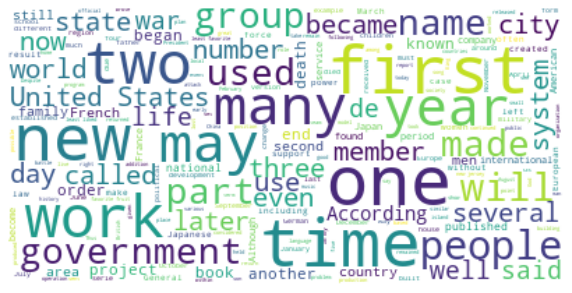

In [25]:
# generate wordcloud for english corpus
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(english_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

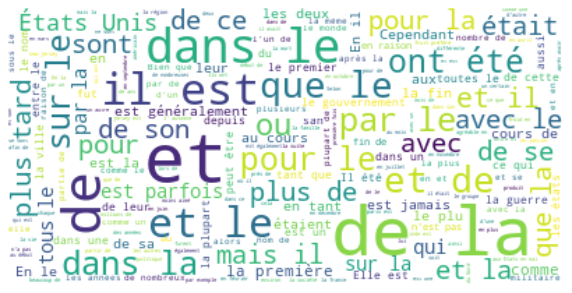

In [26]:
# and for French
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(french_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Although, I didn't get as much information as I though I would from the wordcloud, it was observed that these datasets contained rich, everyday use words that would help much in generalizing for translation of everyday terms

In [27]:
del wordcloud

gc.collect()

5052

### Distribution of word count

Text(0.5, 1.0, 'Word Frequency Distribution in French dataset')

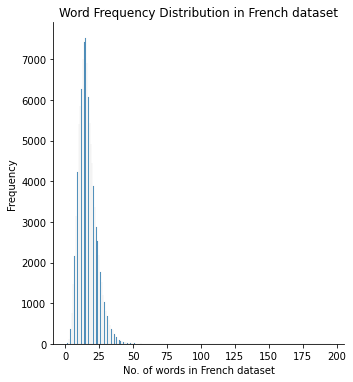

In [28]:
# let's count the number of words in the dataset and see the distribution

fr_text_size = list(map(lambda x: len(x.split()), french_dataset))
sns.displot(fr_text_size)
plt.xlabel('No. of words in French dataset')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in French dataset')

Text(0.5, 1.0, 'Word Frequency Distribution in English dataset')

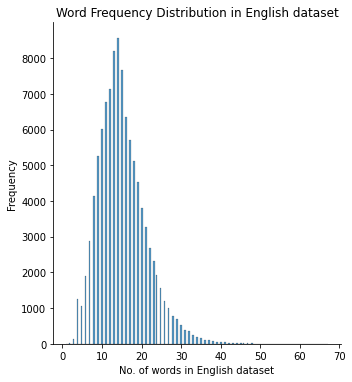

In [29]:
eng_text_size = list(map(lambda x: len(x.split()), english_dataset))
sns.displot(eng_text_size)
plt.xlabel('No. of words in English dataset')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in English dataset')

In [30]:
english_textsize = pd.Series(eng_text_size)
french_textsize = pd.Series(fr_text_size)

In [31]:
english_textsize.head()

0    13
1    15
2    21
3    25
4    10
dtype: int64

In [32]:
french_textsize.head()

0    14
1    15
2    22
3    29
4    11
dtype: int64

In [33]:
eng_mean = english_textsize.mean()
french_mean = french_textsize.mean()

print(f"For English, the average word count per entry is: {eng_mean}")
print(f"For French, the average word count per entry is: {french_mean}")

For English, the average word count per entry is: 15.193217839323507
For French, the average word count per entry is: 16.574491721013974


In [34]:
eng_max = english_textsize.max()
french_max = french_textsize.max()

print(f"For English, the max word count per entry is: {eng_max}")
print(f"For French, the max word count per entry is: {french_max}")

For English, the max word count per entry is: 67
For French, the max word count per entry is: 196


In [35]:
#x = english_textsize[english_textsize.values > 50]
#x

We can see that on average, French uses more words for its sentences than English does.

## Tokenization

We need to add START and END tokens to our texts for the encoder and decoder in the transformer. I added <SOS> - Start of sentence and <EOS> end of sentence to the texts that would be tokenized.

In [36]:
english_dataset[:5]

['The senior officers did not intervene; instead, they stayed in their "pleasant" houses.',
 'Hafezi continued to work to expand the number of people who could benefit from CXL.',
 'Some players even insist that a further announcement (i.e. 90) be made if the announcement in question has been made already.',
 'It participates in the development of knowledge about the distribution, ecology and bird conservation by the development and maintenance of databases appointed EPOQ since 1988.',
 "That's intentional, and that's also just how we sound together."]

In [37]:
for i, text in enumerate(english_dataset[:5]):
    english_dataset[i] = "<SOS> " + english_dataset[i] + " <EOS>"
english_dataset[:5]

['<SOS> The senior officers did not intervene; instead, they stayed in their "pleasant" houses. <EOS>',
 '<SOS> Hafezi continued to work to expand the number of people who could benefit from CXL. <EOS>',
 '<SOS> Some players even insist that a further announcement (i.e. 90) be made if the announcement in question has been made already. <EOS>',
 '<SOS> It participates in the development of knowledge about the distribution, ecology and bird conservation by the development and maintenance of databases appointed EPOQ since 1988. <EOS>',
 "<SOS> That's intentional, and that's also just how we sound together. <EOS>"]

In [38]:
french_dataset[:5]

["Les officiers supérieurs n'intervinrent pas\xa0; ils restèrent dans leurs «\xa0agréables demeures\xa0».",
 'Hafezi a continué à travailler pour augmenter le nombre de personnes pouvant bénéficier de CXL.',
 "Certains joueurs insistent même pour que l'annonce suivante (i.e. pas de 90) soit faite si l'annonce en question a été faite auparavant.",
 'Il participe au développement des connaissances sur la répartition, l’écologie et la conservation des oiseaux par le développement et le maintien de banques de données nommée ÉPOQ depuis 1988.',
 "C'est intentionnel, et c'est aussi la manière que nous sonnons ensemble."]

In [39]:
for i, text in enumerate(french_dataset[:5]):
    french_dataset[i] = "<SOS> " + french_dataset[i] + " <EOS>"
french_dataset[:5]

["<SOS> Les officiers supérieurs n'intervinrent pas\xa0; ils restèrent dans leurs «\xa0agréables demeures\xa0». <EOS>",
 '<SOS> Hafezi a continué à travailler pour augmenter le nombre de personnes pouvant bénéficier de CXL. <EOS>',
 "<SOS> Certains joueurs insistent même pour que l'annonce suivante (i.e. pas de 90) soit faite si l'annonce en question a été faite auparavant. <EOS>",
 '<SOS> Il participe au développement des connaissances sur la répartition, l’écologie et la conservation des oiseaux par le développement et le maintien de banques de données nommée ÉPOQ depuis 1988. <EOS>',
 "<SOS> C'est intentionnel, et c'est aussi la manière que nous sonnons ensemble. <EOS>"]

We'll have two tokenizers for this task. One will handle the English dataset while the other will handle the French dataset. The tokenizer used here is the [one here at TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer). After tokenizing, we'll pad the sequences to the same shape with the pad_sequences utility [provided on TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences). Because of the behavior of the TensorFlow's Tokenizer and pad_sequences - they expect a list of sequences(lists) - we have to be careful at the evaluating stage where we'll expect to treat one sequence at a time. 

Essentially - the Tokenizer class treats ['This is a boy'] on a per-character tokenization scheme since it expects something like `['This is a boy', 'This is a girl']`.... For a single sequence, doing this - `[['This is a boy']]`would yield the intended results. 

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer

num_words = 80000
tokenizer_en = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_en.fit_on_texts(english_dataset)

word_index = tokenizer_en.word_index
print(f"The number of words in the English vocabulary: {len(word_index)}")

The number of words in the English vocabulary: 95477


In [41]:
tokenizer_fr = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_fr.fit_on_texts(french_dataset)

word_index_fr = tokenizer_fr.word_index
print(f"The number of words in the French vocabulary: {len(word_index_fr)}")

The number of words in the French vocabulary: 122978


In [42]:
english_data = tokenizer_en.texts_to_sequences(english_dataset)
french_data = tokenizer_fr.texts_to_sequences(french_dataset)

### Padding

The standard practice in NLP is to set each sequence to the same shape so that the neural network receives same shape of input. 
Now, each sentence in the dataset have varying lengths so we use Keras' pad_sequences function to add 0s to each sequence to the same shape. Just like the Tokenizer above, the pad_sequences expect a list of sequences  (basically going to be a list of lists after tokenization). 

The documentation for the pad_sequences function is here at the [TensorFlow documentation page](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences).

From the statistical work done on the data, we learned that the sentences in the datasets have about a maximum length of 16-20. I'd pad according to the max from each corpus

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# padding according to max length found in dataset
english_data = pad_sequences(english_data, maxlen = 25, padding='post', truncating='post')
french_data = pad_sequences(french_data, maxlen=30, padding='post', truncating='post')

In [44]:
english_data.shape, french_data.shape

((104421, 25), (104421, 30))

In [45]:
# let's see that everything works as intended

test_en = tokenizer_en.sequences_to_texts(english_data[:5])
test_en

['sos the senior officers did not intervene instead they stayed in their pleasant houses. eos',
 'sos hafezi continued to work to expand the number of people who could benefit from cxl. eos',
 'sos some players even insist that a further announcement i.e. 90 be made if the announcement in question has been made already. eos',
 'sos it participates in the development of knowledge about the distribution ecology and bird conservation by the development and maintenance of databases appointed epoq since',
 "sos that's intentional and that's also just how we sound together. eos"]

In [46]:
test_fr = tokenizer_fr.sequences_to_texts(french_data[:5])
test_fr

["sos les officiers supérieurs n'intervinrent pas\xa0 ils restèrent dans leurs \xa0agréables demeures\xa0 . eos",
 'sos hafezi a continué à travailler pour augmenter le nombre de personnes pouvant bénéficier de cxl. eos',
 "sos certains joueurs insistent même pour que l'annonce suivante i.e. pas de 90 soit faite si l'annonce en question a été faite auparavant. eos",
 'sos il participe au développement des connaissances sur la répartition l’écologie et la conservation des oiseaux par le développement et le maintien de banques de données nommée époq depuis 1988.',
 "sos c'est intentionnel et c'est aussi la manière que nous sonnons ensemble. eos"]

In [47]:
# save the tokenizers for future user

import pickle

# for english
with open('tokenizer_en.pickle', 'wb') as handle:
    pickle.dump(tokenizer_en, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
# for french
with open('tokenizer_fr.pickle', 'wb') as handle:
    pickle.dump(tokenizer_fr, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Implementing the Transformer Architecture

### Positional Encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [49]:
def get_angles(pos, i, d_model):
    """Function to compute the angles to embed positional encoding to the tokens to be fed to the transformer"""
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [50]:
def positional_encoding(position, d_model):
    """Adds  positional encoding to the Embeddings to be fed to the Transformer model
    
    Computes a sin and cos of the angles determined by the get_angles() function
    and adds the value computed to an axis of the embeddings
    """
    
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [51]:
# check if the code works as intended
pos_encoding = positional_encoding(50, 512)
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41470957e-01,  5.40302277e-01,  8.21856201e-01, ...,
          1.00000000e+00,  1.03663289e-04,  1.00000000e+00],
        [ 9.09297407e-01, -4.16146845e-01,  9.36414719e-01, ...,
          1.00000000e+00,  2.07326579e-04,  1.00000000e+00],
        ...,
        [ 1.23573124e-01, -9.92335498e-01,  9.77189839e-01, ...,
          9.99987245e-01,  4.87215538e-03,  9.99988139e-01],
        [-7.68254638e-01, -6.40144348e-01,  7.31235921e-01, ...,
          9.99986708e-01,  4.97581763e-03,  9.99987602e-01],
        [-9.53752637e-01,  3.00592542e-01, -1.44026920e-01, ...,
          9.99986112e-01,  5.07947942e-03,  9.99987125e-01]]],
      dtype=float32)>

In [52]:
pos_encoding.shape

TensorShape([1, 50, 512])

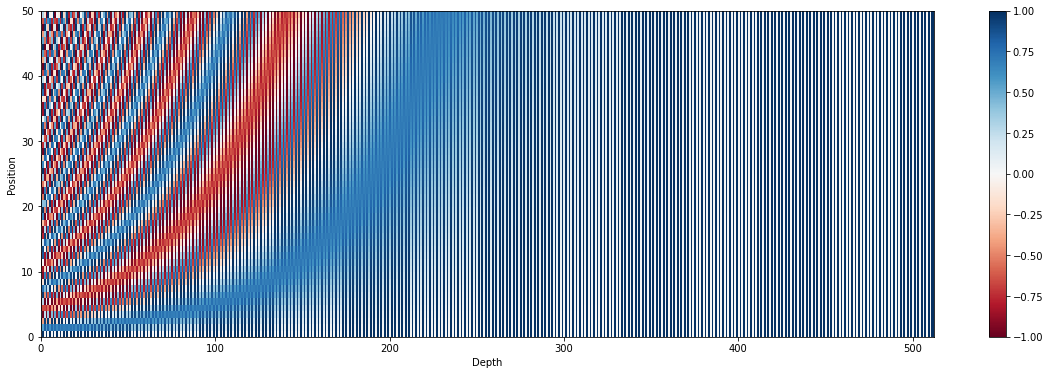

In [53]:
plt.figure(figsize=(20,6))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

(1, 2048, 512)


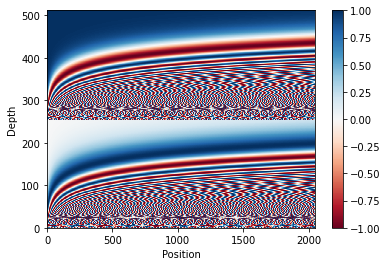

In [54]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

### Attention

![](https://e2eml.school/images/transformers/architecture_single_head.png)

The primary concept to grasp about Transformers is the self-attention or intra attention mechanism. The self in self-attention refers to the fact that the attention weights are computed for all hidden states in the same set - for example, all the hidden states of the encoder. As the transformer model processes each word, self-attention allows it to look at other positions in the input sequences for clues that can help it lead to a better encoding for the particular word.

The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The main idea behind attention is that instead of producing a single hidden state for the input sequence, the encoder outputs a hidden state at each step that the decoder can access. However, using all the states at the same time would create a huge input for the decoder. This is where attention comes in - it lets the decoder assign a different amount of weight or attention to each of the encoder states at every decoding timestep.

Steps:

a. Create three vectors from each of the encoder's input vectors(embeddings of each word). The dimension of the input embeddings is given as d_model in the paper and they used an embedding size of 512. For each attention unit the transformer model learns three weight matrices; the query weights, the key weights, and the value weights. For each token, the input word embedding is multiplied with each of the three weight matrices to produce a query vector Q((vector representation of one word in the sequence), a key vector K (vector representations of all the words in the sequence), and a value vector V(which are the vector representations of all the words in the sequence).

The query Q represents the feature of interest and the matrix K represents the collection of masks. Because it's stored with masks in columns, rather than rows, it needs to be transposed (with the T operator) before multiplying. The vectors q, k, v are smaller in dimension than the embedding vector. The reason for this will be explained soon.

b. Calculate a score: The attention score is calculated by taking the dot product of the query vector and the key vector of the respective word we're scoring. For a sequence of n inputs, we'd have a corresponding n x n matrix of attention scores.

c. Scaling: The attention scores are divided by √dk (dimension of the key vector or depth). This dimension is equal to 64 in the paper, so the matrix of attention scores is scaled by 1/8. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. For example, consider that Q and K have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. So the square root of dk is used for scaling, so you get a consistent variance regardless of the value of dk. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initialization making it difficult to learn

d. Normalized: The attention scores in the matrix are normalized so that they add up to 1. This is done with the softmax function. The matrix obtained after this step is known as the attention weights.

e. Multiply the value vector V for each word by the attention weights and then sum up to produce the output of the self-attention lyer for that position. It is probably helpful to think of the attention weights as where to look and the Value vector as what one wants to actually get. 

In [55]:
def scaled_dot_product_attention(q, k, v, mask):
    """Computes the attention weight for the q, k, v vectors
    
    Attention in the transformer is popularly known as self-attention because the q, k, v vectors are
    sourced from the same sequence. Self Attention, also called intra Attention, is an attention mechanism relating 
    different positions of a single sequence in order to compute a representation of the same sequence.
    
    q, k, v must have leading dimensions - same 'batch_size'
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v
    
    q - query vectors; shape == (..., seq_len_q, depth)
    k - key vectors; shape == (..., seq_len_k, depth)
    v - value vectors; shape == (..., seq_len_v, depth_v)
    
    Returns - attention weights, output
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
    scaled_dk = tf.math.sqrt(dk)
    
    scaled_attention_logits = matmul_qk/scaled_dk
    
    # add mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # softmax the attention logits so it adds up to 1
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [56]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('\nOutput is:')
    print(temp_out)

In [57]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32) # (4, 2)

temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)
                     
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)

Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### Multi-Head Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

Multi-head attention consists of these parts:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer.


The self-attention is refined by carrying it out across several heads. In the paper, they carried out the self-attention step across 8 head. This is known as Multi-Head Attention. Each attention head( (an instance of attention computation) computes its own attention.

So far according to the paper, we have d_model = 512 (dimension of the embeddings), d_k = 64 (dimension of the key and query vectors), and h = 8 (number of attention heads). The paper also used d_v (dimension of the value vector) to be 64 just like the key and query vectors, however this doesn't have to be so.

####  Why is Multi-Head Attention Needed?

Looking at the attention formula given above, we see that the softmax functions which outputs probabilities forces the attention calculation in the range (0, 1) and it helps to emphasize the highest value, while agressively squashing the smallest. The problem with this is that it allows attention to focus on a single element (the one with the highest probability) and leave out the rest which still have a lot of information in them. Sometimes it's useful to keep several of the preceding words in mind when predicting the next, and the softmax just robbed us of that. This is a problem for the model.

The solution to this problem is to have several instances of attention or heads running at once. This lets the the transformer consider several previous words simultaneously when predicting the next. Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. It brings back the power we had before we pulled the softmax into the picture. 

The intuition behind multi-head attention is that it allows us to attend to different parts of the sequence differently each time. This practically means that:

a. The model can better capture positional information because each head will attend to different segments of the input. The combination of them will give us a more robust representation.

b. Each head will capture different contextual information as well, by correlating words in a unique manner.

However, computing many attention heads require a lot of computation. For the attention step to scale well, the query, key and value vectors are projected into lower-dimensional embedding space. This shrinks the matrices involved and dramatically reduces the computation time.

#### Next step:

However, the next step in the transformer architecture is not receiving matrices from *h* attention heads (8 in the paper). It is expecting a single matrix for each word. So, the multi-head attention matrices would need to be condensed:

a. Concatenate all attention matrices into one giant matrix.

b. Multiply the result of a above by Wo (weight matrix) that was trained jointly with the model.

This is shown below:

![](https://e2eml.school/images/transformers/multihead_attention_equation.png)

In [58]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """Computes the attention for several heads in the transformer"""
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model%num_heads == 0 # ensures d_model can be split evenly across heads
        self.depth = self.d_model // self.num_heads
        
        self.wk = tf.keras.layers.Dense(d_model)
        self.wq = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)
         Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def get_config(self):
        """Implement serialization so we can save the model"""
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
        })
    
    def __call__(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # Dense layer on the q, k, v vectors
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # compute attention weights
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # reshape and add Dense layer
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention) #(batch_size, seq_len_q, d_model)
        
        return output, attention_weights

In [59]:
# let's check if this works as intended
temp_multihead = MultiHeadAttention(512, 8)

y = tf.random.uniform((1, 60, 512))
out, attn = temp_multihead(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

### Point-wise Feed Forward Network

The FFN layer in the encoder and decoder is just a simple two-layer fully-connected network which processes each embeddings independently. A rule of thumb from the paper is that the hidden units of the first layer to be 4x the size of the embeddings. That is, dff = 4 x d_model. 
The FFN is labeled as Linear in the transformer architecture diagram above.

In [60]:
def pointwise_feed_forward_network(d_model, dff):
    model = tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), 
                                tf.keras.layers.Dense(d_model)])
    return model

In [61]:
sample_ffn = pointwise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### Encoder Layer

Each encoder layer consists of:

a. Multi-Head Attention layer

b. Feed Forward layer

The encoder layers also include layer normalization and skip connections. This is represented by the Add & Norm section of the transformer architecture diagram above. 

#### Skip Connections
Skip connections occur around the Multi-Head attention blocks and around the element-wise feed forward blocks. Skip connections give a transformer a tiny ability to allow the representations of different levels of processing to interact.

In skip connections, a copy of the input is added to the output of a set of calculations. This is seen in the code block below as the output of the multi-head attention is added to the vector k, q, v again - the inputs to the attention block are added back to its output. Also, the input to the element-wise feed forward network are added to its outputs. 

This serves two purposes:
a. It helps keep the gradient smooth which is a big help for backpropagtion: Attention is a filter, which means that when it is working correctly, it will block most of what tries to pass through it. The result of this is small changes in a lot of the inputs may not produce much change in the output if they happen to fall into the channels that are blocked. This produces dead spots in the gradients where it is flat. Skip connections help to smooth these out.

b. It helps to preserve the original input sequence: Even with lots of attention heads, there's no guarantee a word will attend to its own position. It's possible for the attention filter to forget entirely about the most recent word in favour of watching all of the earlier words that might be relevant. A skip connection takes the original word and manually adds it back into the signal so that there's no way it can be dropped or forgotten.

Thanks to skip connections, successive layers don't provide increasingly sophisticated abstractions as much as they provide redundancy. Whatever opportunities for focusing attention and creating useful features and making accurate predictions were missed in one layer can always be caught by the next.

#### Layer Normalization

The values of the matrix are shifted to have a mean of zero and scaled to have a standard deviation of one.

In [62]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """Initializes the encoder layer
        
        Args: 
            d_model: depth of the transformer model
            num_heads: number of heads for multi-head attention
            dff: depth of the feed forward network
            rate: dropout rate for training
        """
        super(EncoderLayer, self).__init__()
        self.multihead = MultiHeadAttention(d_model, num_heads)
        self.ffn = pointwise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def __call__(self, x, training, mask):
        attn_output, _ = self.multihead(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(attn_output + x)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(ffn_output + out1)
        
        return out2

In [63]:
# test
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, mask=None)
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

I'll skip the explanation of differences until we stack up the decoder layers later below

In [64]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """Initialize a decoder layer"""
        super(DecoderLayer, self).__init__()
        self.multihead1 = MultiHeadAttention(d_model, num_heads)
        self.multihead2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = pointwise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def __call__(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """x - query vector for the Decoder
        enc_output - a set of attention vectors k and v from the top Encoder layer
        training - mode for Dropout
        look_ahead_mask/padding_mask - required for MultiHeadAttention
        """
        attn1, attn_weights_block1 = self.multihead1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # becomes the query vector for the next MultiHeadAttention
        
        attn2, attn_weights_block2 = self.multihead2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

In [65]:
# let's test this out
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(x=tf.random.uniform((64, 50, 512)), enc_output=sample_encoder_layer_output, 
                                                        training=False, look_ahead_mask=None, padding_mask=None)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

### The Encoder

The Encoder class implemented below consists of the following layers:

a. Embedding layer

b. Positional Encoding

c. Stacks of the encoder sublayers

#### Embedding

Word embeddings are a representation of a symbol (word, character, sentence) in a distributed low-dimensional space of continuous-valued vectors. Word embeddings map human language into a structured geometric space. As opposed to one-hot encodings, word embeddings consist of floating-point vectors (that is, dense vectors as opposed to sparse vectors). It’s common to seeword embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional unlike the one-hot encoding paradign with thousands of dimensions. This means that embeddings packs more information into far fewer dimensions (high embedding dimensions is more information retained).

A good embedding groups words with similar meanings together. A model that works with an embedding learns patterns in the embedded space. That means that whatever it learns to do with one word automatically gets applied to all the words right next to it. This has the added benefit of reducing the amount of training data needed. Each example gives a little bit of learning that gets applied across a whole neighborhood of words. The embeddings is done below with the tf.keras,Embedding(sequence_length, embedding_dimensionality). The dimension for embedding (from the paper) is d_model = 512.

#### Positional Encoding

As explained in the section above, position information need to be added to the word embeddings. As it's an addition operation, it doesn't alter the shape of the embeddings vector. 

#### Stack of Encoder sublayers

Asides the embeddings and positional encoding, the rest of the encoder consists of multi-head attention block and the element-wise feed forward network. Each encoder sublayer passes its output to the next encoder layer until the end which is then passed on to the decoder for the decoding to begin. The number of encoding sublayers can also be controlled by the num_layers argument (6 layers was used in the paper) in the code below

In [66]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        # create the embedding layer and add positional encoding
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate=rate)
        
    def __call__(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # add embeddings and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # tf.math.sqrt doesn't support int types
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

In [67]:
# let's test this
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### The Decoder

Just like the Encoder, the Decoder also consists of the:

a. Embedding

b. Positional encoding

c. Stacks of decoding layers.

The output of the decoder is passed on to the final layer which is followed by a softmax layer so it outputs the probabilities of a particular word for every step.

A major difference between the Encoder and the Decoder is that the decoder has two attention sublayers

a. Masked multi-head attention layer: ensures that the tokens we generate at each timestep are only based on the past outputs and current tokens being predicted. To achieve this, we mask the next word embeddings (by setting them to −inf)

b. Encoder - decoder attention layer:This is actually where the decoder processes the encoded representation. The attention matrix generated by the encoder is passed to another attention layer alongside the result of the previous Masked Multi-head attention block.

This performs multihead attention over the output key and value vectors of the encoder stack with the intermediate representations of the decoder acting as the queries. The output of the top encoder is transformed into a set of attention vectors K and V. These are to be used by each decoder in its encoder-decoder attention layer. These are to be used by each decoder focus on appropriate places in the input sequence.

The results of the decoder inputs are embedded with positional encoding to indicate the position of each word. 
The self-attention layer in the decoder is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions.

In [68]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        # embedding + positional encoding
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dropout = tf.keras.layers.Dropout(rate)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
    def __call__(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f"decoder_layer{i + 1}_block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_block2"] = block2
            
        return x, attention_weights

In [69]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

### Masking

In [70]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimension to add padding to the attention logits
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [71]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [72]:
def create_masks(inp, tar):
    # encoder padding mask (also necessary for 2nd attention block in the decoder)
    enc_padding_mask = create_padding_mask(inp)
        
    # dec padding mask - used in the 2nd attention block in the decoder
    dec_padding_mask = create_padding_mask(inp)
        
    # used in the first attention block
    # used to pad and mask future tokens in the tokens received by the decoder
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
    return enc_padding_mask, combined_mask, dec_padding_mask

### The Transformer

![](https://miro.medium.com/max/700/1*BHzGVskWGS_3jEcYYi6miQ.png)

Let's offer a high-level explanation of the transformer architecture here:

a. The Transformer consists of two arms - the Encoder and Decoder. The Encoder generates a rich vector representation of the input while the decoder predicts the next token based on the tokens it's being fed. The transformer architecture can be used for sequence-sequence tasks like translation.

b. The input to the Encoder is the word vectors obtained after tokenizing and padding the sequences from the text input. The STARTOFSEQUENCE and ENDOFSEQUENCE tokens needs to be added at the start and end of each text input. 

c. A dense vector embeddings of the input text is created. Positional encodings are added to the embeddings and this is fed to several attention heads. Layer normalization and skip connections are involved with this process so as to ensure smooth gradients for backpropagation.

d. The Encoder has N encoder sublayers and the output of one is passed to the next and the output at the top encoder is passed to the decoder.

e. The decoder has almost the exact architecture as the decoder but it computes a second type of attention - ensuring that future predictions only take the current and past tokens into considerations. This is done via masking as implemented in the previous section.

f. The output of the top decoder is passed through a final Dense layer and a softmax layer to output probabilities at each position step. At each step of prediction, the decoder uses only the current and past tokens, and the token with the highest probability at that stage is the output which is further being decoded to have it in text.

In [73]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, 
                 pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def __call__(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [74]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, enc_padding_mask=None, look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Training the Transformer Model

### Set Hyperparameters

In [75]:
d_model = 128
dff = 512
num_layers = 4
num_heads = 8
dropout_rate = 0.1

input_vocab_size = len(tokenizer_en.word_index) + 2
target_vocab_size = len(tokenizer_fr.word_index) + 2

### Loss and Metrics

In [76]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [77]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

### Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [78]:
# learning rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [79]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)

Text(0.5, 0, 'Train Step')

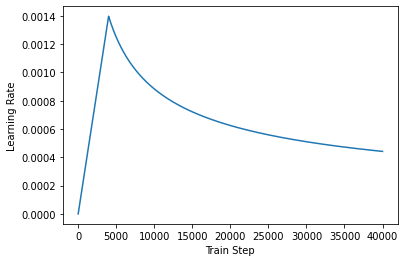

In [80]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Training

In [81]:
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, 
                         pe_input=input_vocab_size, pe_target = target_vocab_size, rate=dropout_rate)

In [82]:
transformer

In [83]:
# chk points
checkpoint_path = "./train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [84]:
EPOCHS = 30

In [85]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(61, 30), dtype=tf.int64),
    tf.TensorSpec(shape=(61,25), dtype=tf.int64),
]

    
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, 
                                     combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [86]:
start_pt = 0

In [87]:
english_data.shape, french_data.shape

((104421, 25), (104421, 30))

In [88]:
batch_size = 61

In [89]:
inp = tf.convert_to_tensor(np.array(french_data[start_pt:start_pt+batch_size]),dtype=tf.int64)
tar = tf.convert_to_tensor(np.array(english_data[start_pt:start_pt+batch_size]),dtype=tf.int64)

In [90]:
len(french_data)

104421

In [91]:
from tensorflow import keras
import time
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  start_pt = 0
  # inp -> portuguese, tar -> english
  for i in range(int(len(english_data)/batch_size)):
    inp = tf.convert_to_tensor(np.array(french_data[start_pt:start_pt+batch_size]),dtype=tf.int64)
    tar = tf.convert_to_tensor(np.array(english_data[start_pt:start_pt+batch_size]),dtype=tf.int64)
    start_pt = start_pt + batch_size
    train_step(inp, tar)
    
    if i % 100 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, i, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Total time taken for that epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 11.7235 Accuracy 0.0000
Epoch 1 Batch 100 Loss 11.6323 Accuracy 0.0175
Epoch 1 Batch 200 Loss 11.3573 Accuracy 0.0195
Epoch 1 Batch 300 Loss 10.9337 Accuracy 0.0211
Epoch 1 Batch 400 Loss 10.4308 Accuracy 0.0247
Epoch 1 Batch 500 Loss 9.9475 Accuracy 0.0274
Epoch 1 Batch 600 Loss 9.5803 Accuracy 0.0292
Epoch 1 Batch 700 Loss 9.3139 Accuracy 0.0306
Epoch 1 Batch 800 Loss 9.1009 Accuracy 0.0330
Epoch 1 Batch 900 Loss 8.9155 Accuracy 0.0363
Epoch 1 Batch 1000 Loss 8.7526 Accuracy 0.0396
Epoch 1 Batch 1100 Loss 8.6070 Accuracy 0.0431
Epoch 1 Batch 1200 Loss 8.4744 Accuracy 0.0465
Epoch 1 Batch 1300 Loss 8.3444 Accuracy 0.0496
Epoch 1 Batch 1400 Loss 8.2156 Accuracy 0.0527
Epoch 1 Batch 1500 Loss 8.1004 Accuracy 0.0555
Epoch 1 Batch 1600 Loss 7.9953 Accuracy 0.0584
Epoch 1 Batch 1700 Loss 7.8996 Accuracy 0.0610
Epoch 1 Loss 7.8909 Accuracy 0.0612
Total time taken for that epoch: 419.8029897212982 secs

Epoch 2 Batch 0 Loss 6.9600 Accuracy 0.0977
Epoch 2 Batch 100 Loss 6

KeyboardInterrupt: ignored

In [92]:
tokenizer_fr.texts_to_sequences(['EOS'])

[[19423]]

## Evaluation

In [93]:
maxlen = 25 # the max token size for target

In [94]:
def evaluate(sentence):
    sentence = '<SOS> '+ sentence[0] +'<EOS>'
    sentence = [sentence] # done because of the way TensorFlow's tokenizer
    
    # vectorize and pad the sentence
    sentence = tokenizer_fr.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, maxlen=17, padding='post', truncating='post')
    
    inp = tf.convert_to_tensor(np.array(sentence),dtype=tf.int64) # convert input to tensors
    
    # tokenize the start of the decoder input & convert to tensor
    decoder_input = tokenizer_en.texts_to_sequences(['SOS'])
    decoder_input = tf.convert_to_tensor(np.array(decoder_input), dtype=tf.int64)
    
    for i in range(maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, decoder_input)
        predictions, attention_weights = transformer(inp, decoder_input,False,enc_padding_mask,combined_mask, dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.texts_to_sequences(['EOS']):
            return tf.squeeze(decoder_input, axis=0)
        
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        decoder_input = tf.concat([decoder_input, predicted_id], axis=1)
    return tf.squeeze(decoder_input, axis=0)

In [95]:
def translate(sentence):
    sentence = [sentence] # our evaluate function requires lists
    print('Input: {}'.format(sentence[0]))
    print("Please wait while we translate: \n")
    result = evaluate(sentence)
    
    predicted_sentence = tokenizer_en.sequences_to_texts([[i for i in result.tolist() if i != tokenizer_en.texts_to_sequences(['SOS'])[0][0]]
                                                         or i != tokenizer_en.texts_to_sequences(['EOS'])[0][0]])  

    
    print('Predicted translation: {}'.format(predicted_sentence[0]))

In [96]:
sentence = "Je vous aime."
translate(sentence)

Input: Je vous aime.
Please wait while we translate: 

Predicted translation: i love you. don't friends. and friends. friends. . . . . . i love. you. you. you. . . . . . . .


In [97]:
sentence = "J'adore manger des bananes."
translate(sentence)

Input: J'adore manger des bananes.
Please wait while we translate: 

Predicted translation: love love to eat musical friends. them. them. . . . . . love . . . . . . . . . . .


In [98]:
sentence = "C'est un triste jour dans le New Jersey."
translate(sentence)

Input: C'est un triste jour dans le New Jersey.
Please wait while we translate: 

Predicted translation: it is a sad day in new jersey. music. only a sad day. . . . . . . . . . . . .


In [99]:
sentence = "J'ai eu une très belle conversation avec toi."
translate(sentence)

Input: J'ai eu une très belle conversation avec toi.
Please wait while we translate: 

Predicted translation: i had a very beautiful conversation with you. friends. . . . . i had a beautiful conversation. . . . . . . with


In [100]:
sentence = "Le professeur ne m'aime pas."
translate(sentence)

Input: Le professeur ne m'aime pas.
Please wait while we translate: 

Predicted translation: professor does not state a poetry. said. not. . the professor not. . . . . . . . . . . . . .


In [101]:
sentence = "L'entreprise a fait faillite."
translate(sentence)

Input: L'entreprise a fait faillite.
Please wait while we translate: 

Predicted translation: the company went went july friends. friends. . . . . . the company has went together. state not. them. them. them. 000. them. .


In [102]:
sentence = "Le médecin ordonne à Daniel de regarder le film."
translate(sentence)

Input: Le médecin ordonne à Daniel de regarder le film.
Please wait while we translate: 

Predicted translation: the doctor ordered daniel to look to watch the movie. movie. movie. movie. movie. . . . . . . . . . . .


In [103]:
sentence = "Regardez les étoiles dans le ciel et non vos pieds."
translate(sentence)

Input: Regardez les étoiles dans le ciel et non vos pieds.
Please wait while we translate: 

Predicted translation: look out stars in the sky and not your feet. and don't your feet. feet. and feet. feet. and feet. and . . . your


In [104]:
sentence = "Ce n'est pas très spécial."
translate(sentence)

Input: Ce n'est pas très spécial.
Please wait while we translate: 

Predicted translation: it is not very special and white. friends. friends. friends. . . . . . . . . . . . . . . .


In [105]:
sentence = "Albert Einstein est un physicien intelligent."
translate(sentence)

Input: Albert Einstein est un physicien intelligent.
Please wait while we translate: 

Predicted translation: albert einstein is a scientist a a a a a per fact of the fact albert einstein is a a a a a a a


In [106]:
sentence = "Le médecin a expliqué au patient comment le sang circule dans le corps à l'aide d'un schéma."
translate(sentence)

Input: Le médecin a expliqué au patient comment le sang circule dans le corps à l'aide d'un schéma.
Please wait while we translate: 

Predicted translation: the doctor explained the patient how blood the blood took place in the body to help from a help. with the help. de a help.


In [107]:
sentence = "J'ai travaillé très dur pour cela."
translate(sentence)

Input: J'ai travaillé très dur pour cela.
Please wait while we translate: 

Predicted translation: i worked very hard for this. and that. . . . . i worked very hard for this. friends. . . . . . .


In [108]:
sentence = "L'artiste a sorti un clip vidéo pour accompagner son album."
translate(sentence)

Input: L'artiste a sorti un clip vidéo pour accompagner son album.
Please wait while we translate: 

Predicted translation: the artist released a video video to accompany her album a album. musicians. album. . . . . . . . . . . .


In [109]:
sentence = "Jouez cette chanson encore et encore et encore."
translate(sentence)

Input: Jouez cette chanson encore et encore et encore.
Please wait while we translate: 

Predicted translation: this song still and even and even friends. am friends. . . . this song again. and more. again. again. again. again. . . .


In [110]:
sentence = "Rien ne dure éternellement - même une pluie froide de novembre."
translate(sentence)

Input: Rien ne dure éternellement - même une pluie froide de novembre.
Please wait while we translate: 

Predicted translation: nothing is forever hard a cold rain of november. november. . . . . . . . . . . . . . . .


In [111]:
sentence = "Je n'essaie plus de survivre."
translate(sentence)

Input: Je n'essaie plus de survivre.
Please wait while we translate: 

Predicted translation: i try to try more than survive. friends. friends. . . . . . . . . . . . . . . . .


In [128]:
sentence = "Albert est né chrétien mais devient musulman."
translate(sentence)

Input: Albert est né chrétien mais devient musulman.
Please wait while we translate: 

Predicted translation: albert was born christian but becomes muslim a number of friends. and albert was restored. christian. . . . . . . . . .


## Resources

Heavy inspiration - 

On Understanding how the architecture works
* https://jalammar.github.io/illustrated-transformer/
* https://e2eml.school/transformers.html
* https://theaisummer.com/skip-connections/#u-nets-long-skip-connections
* https://theaisummer.com/transformer/

On Implementation
* https://www.tensorflow.org/text/tutorials/transformer

* https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/tensorflow/transformer.ipynb#scrollTo=s_qNSzzyaCbD

* https://colab.research.google.com/drive/1CBe2VlogbyXzmIyRQGH5xzuvLwGrvjcf?usp=sharing#scrollTo=y7TFAAnXklib

* https://sungwookyoo.github.io/study/Transformer/
* https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb#scrollTo=iYQdOO1axwEI

## Future Work - Exporting the Transformer

In [119]:
def preprocess_english(sentence, maxlen=30):
    """Helper function to preprocess the Input sentence.
    Returns the Input Sentence after tokenizing and vectorization
    """
    print(f"Input Sentence: {sentence}")
    sentence = [sentence]
    sentence = '<SOS> '+ sentence[0] +'<EOS>'
    sentence = [sentence] # done because of the way TensorFlow's tokenizer
    
    # vectorize and pad the sentence
    sentence = tokenizer_fr.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, maxlen=17, padding='post', truncating='post')
    sentence = np.array(sentence)
    
    # tokenize the start of the decoder input & convert to tensor
    decoder_input = tokenizer_en.texts_to_sequences(['SOS'])
    decoder_input = np.array(decoder_input)
    
    return sentence, decoder_input

In [120]:
class Translator(tf.Module):
    def __init__(self, tokenizer_en, tokenizer_fr, transformer):
        self.tokenizer_en = tokenizer_en
        self.tokenizer_fr = tokenizer_fr
        self.transformer = transformer
        
    def __call__(self, sentence, decoder_input, maxlen = 30):
        inp = tf.convert_to_tensor(sentence,dtype=tf.int64) # convert input to tensors
        decoder_input = tf.convert_to_tensor(decoder_input, dtype=tf.int64)
        
        for i in range(maxlen):
            enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, decoder_input)
            predictions, attention_weights = self.transformer(inp, decoder_input,False,enc_padding_mask,combined_mask, dec_padding_mask)
            
            # select the last word from the seq_len dimension
            predictions = predictions[: ,-1:, :] 
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
            
            # return the result if the predicted_id is equal to the end token
            if predicted_id == self.tokenizer_en.texts_to_sequences(['EOS']):
                result = tf.squeeze(decoder_input, axis=0)
            
            # concatentate the predicted_id to the output which is given to the decoder
            # as its input.
            decoder_input = tf.concat([decoder_input, predicted_id], axis=1)
        result = tf.squeeze(decoder_input, axis=0)
        return result

In [121]:
def print_translation(result):
    predicted_sentence = tokenizer_en.sequences_to_texts([[i for i in result.tolist() if i != tokenizer_en.texts_to_sequences(['SOS'])[0][0]]
                                                         or i != tokenizer_en.texts_to_sequences(['EOS'])[0][0]])  
    print(f"Model's translation: {predicted_sentence[0]}")

In [122]:
# sanity check
sentence = "Je n'essaie plus de survivre."
sentence, decoder_input = preprocess_english(sentence)
sentence

Input Sentence: Je n'essaie plus de survivre.


array([[ 9856,    68, 26360,    21,     1, 14692, 19423,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [123]:
# initialize and use the Translator class
translator = Translator(tokenizer_en, tokenizer_fr, transformer)
translation = translator(sentence, decoder_input)
print_translation(translation)

Model's translation: i try to try more than survive. friends. friends. . . . . . . . . . . . . . . . . . . . . .


Need to figure out how to work beyond this point.

In [124]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.int64), tf.TensorSpec(shape=[], dtype=tf.int64)])
    def __call__(self, sentence, decoder_input):
        result = self.translator(sentence, decoder_input)
        return result

In [125]:
reload = ExportTranslator(translator)

In [ ]:
# to make a translation
translation = reload(sentence=sentence, decoder_input=decoder_input)
translation

In [ ]:
# to save the model
tf.saved_model.save(reload, export_dir='translator')

In [ ]:
# to load the model
reloaded_model = tf.saved_model.load('translator')

In [ ]:
# to make a translation with the model saved to storage
translation = reload_model(sentence=sentence, decoder_input=decoder_input)
translation